#Raw dataset

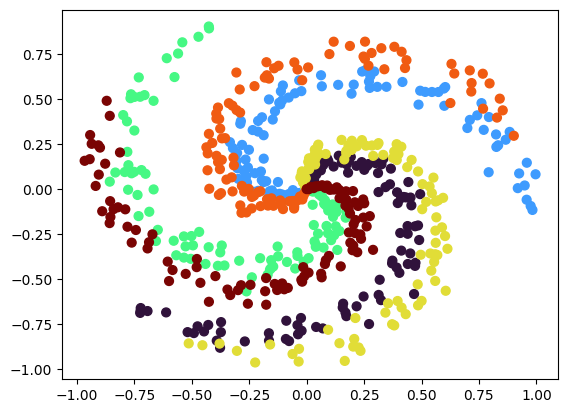

In [79]:
# Code for creating a spiral dataset from CS231n
import numpy as np
import matplotlib.pyplot as plt

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
N = 100 # number of points per class
D = 2 # dimensionality
K = 6 # number of classes
X = np.zeros((N*K,D)) # data matrix (each row = single example)
y = np.zeros(N*K, dtype='uint8') # class labels
for j in range(K):
  ix = range(N*j,N*(j+1))
  r = np.linspace(0.0,1,N) # radius
  t = np.linspace(j*4,(j+1)*4,N) + np.random.randn(N)*0.2 # theta
  X[ix] = np.c_[r*np.sin(t), r*np.cos(t)]
  y[ix] = j
# lets visualize the data
plt.scatter(X[:, 0], X[:, 1], c=y, cmap = "turbo", s=40)
plt.show()

In [2]:
import torch
from torch import nn
from sklearn.model_selection import train_test_split

# Preprocess dataset

In [3]:
X = torch.from_numpy(X).type(torch.float32)
Y = torch.from_numpy(y).type(torch.LongTensor)

In [4]:
#Split
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, train_size = 0.8, random_state = 42)

# Create model

In [30]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [63]:
class UzumakiClassification(nn.Module):
  def __init__(self):
    super().__init__()

    self.linear_stack = nn.Sequential(
        nn.Linear(in_features = 2, out_features = 8),
        nn.ReLU(),
        nn.Linear(in_features = 8, out_features = 16),
        nn.ReLU(),
        nn.Linear(in_features = 16, out_features = 32),
        nn.ReLU(),
        nn.Linear(in_features = 32, out_features = 32),
        nn.ReLU(),
        nn.Linear(in_features = 32, out_features = 16),
        nn.ReLU(),
        nn.Linear(in_features = 16, out_features = 8),
        nn.ReLU(),
        nn.Linear(in_features = 8, out_features = 6) #last output feature = how many class
    )


  def forward(self, x:torch.Tensor) -> torch.Tensor:
    return self.linear_stack(x)

model = UzumakiClassification().to(device)

model

UzumakiClassification(
  (linear_stack): Sequential(
    (0): Linear(in_features=2, out_features=8, bias=True)
    (1): ReLU()
    (2): Linear(in_features=8, out_features=16, bias=True)
    (3): ReLU()
    (4): Linear(in_features=16, out_features=32, bias=True)
    (5): ReLU()
    (6): Linear(in_features=32, out_features=32, bias=True)
    (7): ReLU()
    (8): Linear(in_features=32, out_features=16, bias=True)
    (9): ReLU()
    (10): Linear(in_features=16, out_features=8, bias=True)
    (11): ReLU()
    (12): Linear(in_features=8, out_features=6, bias=True)
  )
)

# loss function and optimizer

In [64]:
loss_fn = nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(params = model.parameters(), lr = 0.05)

In [65]:
def accuracy_fn(Y_true, Y_pred):
  correct = torch.eq(Y_true, Y_pred).sum().item()
  acc = (correct/len(Y_pred))*100
  return acc

In [66]:
#Device

X_train, X_test = X_train.to(device), X_test.to(device)
Y_train, Y_test = Y_train.to(device), Y_test.to(device)



In [67]:
epochs = 1000

for epoch in range(epochs):

  model.train()

  # 1. Forward pass
  y_logits = model(X_train)
  y_pred_probs = torch.softmax(y_logits, dim = 1)
  y_pred = torch.argmax(y_pred_probs, dim = 1)


  loss = loss_fn(y_logits, Y_train)
  train_acc = accuracy_fn(Y_train, y_pred)

  optimizer.zero_grad()

  loss.backward()


  optimizer.step()

  ### Testing
  model.eval()
  with torch.inference_mode():
    test_logits = model(X_test)
    test_pred = torch.argmax(torch.softmax(test_logits, dim = 1), dim = 1)

    # 2. Caculate the loss/acc
    test_loss = loss_fn(test_logits, Y_test)
    test_acc = accuracy_fn(Y_test, test_pred)

  # Print out what's happening
  if epoch % 100 == 0:
    print(f"Epoch: {epoch} | Train Loss: {loss:.2f}, Train accuracy: {train_acc: .2f}% | Test loss: {test_loss:.2f}, Test accuracy: {test_acc:.2f}%")

Epoch: 0 | Train Loss: 1.80, Train accuracy:  16.88% | Test loss: 1.80, Test accuracy: 15.83%
Epoch: 100 | Train Loss: 0.59, Train accuracy:  76.46% | Test loss: 0.51, Test accuracy: 81.67%
Epoch: 200 | Train Loss: 0.24, Train accuracy:  90.83% | Test loss: 0.40, Test accuracy: 85.83%
Epoch: 300 | Train Loss: 0.16, Train accuracy:  93.96% | Test loss: 0.32, Test accuracy: 85.83%
Epoch: 400 | Train Loss: 0.16, Train accuracy:  94.17% | Test loss: 0.34, Test accuracy: 89.17%
Epoch: 500 | Train Loss: 0.14, Train accuracy:  93.33% | Test loss: 0.37, Test accuracy: 88.33%
Epoch: 600 | Train Loss: 0.13, Train accuracy:  93.96% | Test loss: 0.45, Test accuracy: 85.83%
Epoch: 700 | Train Loss: 0.35, Train accuracy:  87.50% | Test loss: 0.33, Test accuracy: 88.33%
Epoch: 800 | Train Loss: 0.14, Train accuracy:  94.58% | Test loss: 0.60, Test accuracy: 86.67%
Epoch: 900 | Train Loss: 0.17, Train accuracy:  92.08% | Test loss: 0.39, Test accuracy: 88.33%


In [76]:
import numpy as np

# TK - this could go in the helper_functions.py and be explained there
def plot_decision_boundary(model, X, y):

    # Put everything to CPU (works better with NumPy + Matplotlib)
    model.to("cpu")
    X, y = X.to("cpu"), y.to("cpu")

    # Source - https://madewithml.com/courses/foundations/neural-networks/
    # (with modifications)
    x_min, x_max = X[:, 0].min() - 0.1, X[:, 0].max() + 0.1
    y_min, y_max = X[:, 1].min() - 0.1, X[:, 1].max() + 0.1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 101),
                         np.linspace(y_min, y_max, 101))

    # Make features
    X_to_pred_on = torch.from_numpy(np.column_stack((xx.ravel(), yy.ravel()))).float()

    # Make predictions
    model.eval()
    with torch.inference_mode():
        y_logits = model(X_to_pred_on)

    # Test for multi-class or binary and adjust logits to prediction labels
    if len(torch.unique(y)) > 2:
        y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1) # mutli-class
    else:
        y_pred = torch.round(torch.sigmoid(y_logits)) # binary

    # Reshape preds and plot
    y_pred = y_pred.reshape(xx.shape).detach().numpy()
    plt.contourf(xx, yy, y_pred, cmap = "turbo", alpha=0.7)
    plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap="turbo")
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())

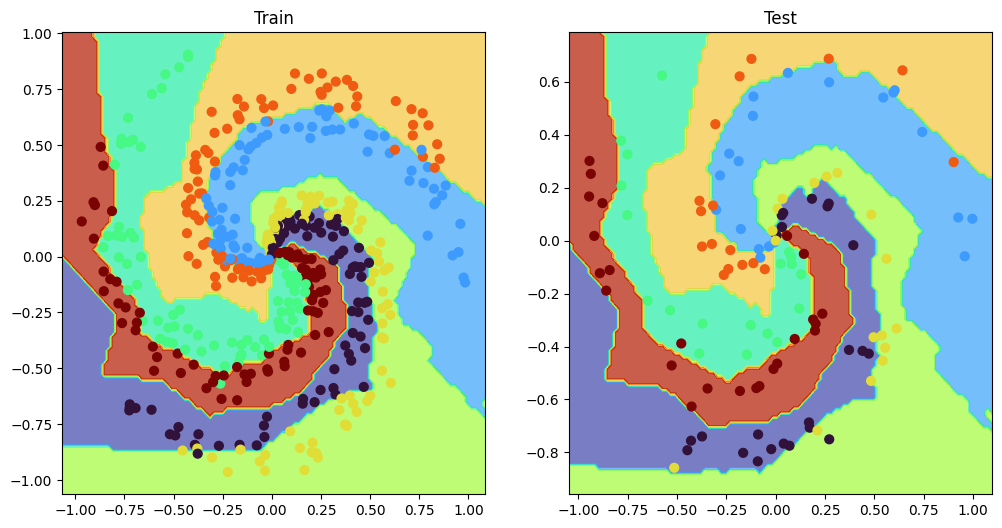

In [77]:
# Plot decision boundaries for training and test sets
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model, X_train, Y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model, X_test, Y_test)
